## Part 1: Cluster Analysis

In [199]:
import os
import numpy as np
import pandas as pd
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(data, name):
    le = preprocessing.LabelEncoder()
    data[name] = le.fit_transform(data[name])
    return le.classes_

## KMeans Implementation

In [200]:
import pandas as pd
imdb_dataset = pd.read_csv("./imdb_dataset.csv")
imdb_dataset

,Unnamed: 0,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,Death Defying Acts,Feature Film,Drama,97.0,PG,Genius Productions,2008,7,11,...,no,no,Gillian Armstrong,Guy Pearce,Catherine Zeta-Jones,Timothy Spall,Saoirse Ronan,Jack Bailey,http://www.imdb.com/title/tt0472071/,//www.rottentomatoes.com/m/death_defying_acts/
647,648,Half Baked,Feature Film,Comedy,82.0,R,Universal Pictures,1998,1,16,...,no,no,Tamra Davis,Dave Chappelle,Guillermo Diaz,Jim Breuer,Harland Williams,Rachel True,http://www.imdb.com/title/tt0120693/,//www.rottentomatoes.com/m/half_baked/
648,649,Dance of the Dead,Feature Film,Action & Adventure,87.0,R,Grindhouse Entertainment,2008,3,9,...,no,no,Gregg Bishop,Jared Kusnitz,Greyson Chadwick,Chandler Darby,Carissa Capobianco,Randy McDowell,http://www.imdb.com/title/tt0926063/,//www.rottentomatoes.com/m/1203339-dance_of_th...
649,650,Around the World in 80 Days,Feature Film,Action & Adventure,120.0,PG,Buena Vista Pictures,2004,6,16,...,no,yes,Frank Coraci,Jackie Chan,Steve Coogan,Ewen Bremner,Robert Fyfe,Ian McNeice,http://www.imdb.com/title/tt0327437/,//www.rottentomatoes.com/m/around_the_world_in...


### Vertical Partitioning

In [201]:
db = imdb_dataset[["title", "genre", "mpaa_rating", "critics_rating"]]
db

,title,genre,mpaa_rating,critics_rating
0,Filly Brown,Drama,R,Rotten
1,The Dish,Drama,PG-13,Certified Fresh
2,Waiting for Guffman,Comedy,R,Certified Fresh
3,The Age of Innocence,Drama,PG,Certified Fresh
4,Malevolence,Horror,R,Rotten
...,...,...,...,...
646,Death Defying Acts,Drama,PG,Rotten
647,Half Baked,Comedy,R,Rotten
648,Dance of the Dead,Action & Adventure,R,Fresh
649,Around the World in 80 Days,Action & Adventure,PG,Rotten


In [202]:
db2 = imdb_dataset[["title", "imdb_rating", "critics_score", "audience_score"]]
db2

,title,imdb_rating,critics_score,audience_score
0,Filly Brown,5.5,45,73
1,The Dish,7.3,96,81
2,Waiting for Guffman,7.6,91,91
3,The Age of Innocence,7.2,80,76
4,Malevolence,5.1,33,27
...,...,...,...,...
646,Death Defying Acts,5.9,44,26
647,Half Baked,6.7,29,81
648,Dance of the Dead,5.9,80,52
649,Around the World in 80 Days,5.8,31,34


### K-Cluster

In [203]:
from sklearn import cluster

data = db2.drop('title',axis=1)
k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(data) 
labels = k_means.labels_
pd.DataFrame(labels, index=db2.title, columns=['Cluster ID'])

c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,Cluster ID
title,
Filly Brown,1
The Dish,0
Waiting for Guffman,0
The Age of Innocence,0
Malevolence,1
...,...
Death Defying Acts,1
Half Baked,1
Dance of the Dead,0


In [204]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=data.columns)

,imdb_rating,critics_score,audience_score
0,7.165363,79.547486,75.164804
1,5.671672,30.979522,46.720137


In [205]:
import numpy as np

testData = np.array(db2[["imdb_rating", "critics_score", "audience_score"]].values)
labels = k_means.predict(testData)
labels = labels.reshape(-1,1)
titles = np.array(db2['title']).reshape(-1,1)
cols = db2.columns.tolist()
cols.append('Cluster ID')
newusers = pd.DataFrame(np.concatenate((titles, testData, labels), axis=1),columns=cols)
newusers

c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,title,imdb_rating,critics_score,audience_score,Cluster ID
0,Filly Brown,5.5,45.0,73.0,1
1,The Dish,7.3,96.0,81.0,0
2,Waiting for Guffman,7.6,91.0,91.0,0
3,The Age of Innocence,7.2,80.0,76.0,0
4,Malevolence,5.1,33.0,27.0,1
...,...,...,...,...,...
646,Death Defying Acts,5.9,44.0,26.0,1
647,Half Baked,6.7,29.0,81.0,1
648,Dance of the Dead,5.9,80.0,52.0,0
649,Around the World in 80 Days,5.8,31.0,34.0,1


c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Text(0, 0.5, 'SSE')

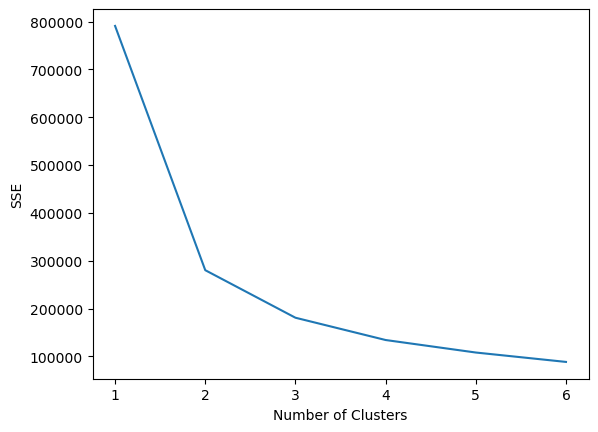

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

## Hierarchical Analysis

In [207]:
import pandas as pd

imdb_dataset = pd.read_csv("./imdb_dataset.csv")
imdb_dataset

,Unnamed: 0,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,Death Defying Acts,Feature Film,Drama,97.0,PG,Genius Productions,2008,7,11,...,no,no,Gillian Armstrong,Guy Pearce,Catherine Zeta-Jones,Timothy Spall,Saoirse Ronan,Jack Bailey,http://www.imdb.com/title/tt0472071/,//www.rottentomatoes.com/m/death_defying_acts/
647,648,Half Baked,Feature Film,Comedy,82.0,R,Universal Pictures,1998,1,16,...,no,no,Tamra Davis,Dave Chappelle,Guillermo Diaz,Jim Breuer,Harland Williams,Rachel True,http://www.imdb.com/title/tt0120693/,//www.rottentomatoes.com/m/half_baked/
648,649,Dance of the Dead,Feature Film,Action & Adventure,87.0,R,Grindhouse Entertainment,2008,3,9,...,no,no,Gregg Bishop,Jared Kusnitz,Greyson Chadwick,Chandler Darby,Carissa Capobianco,Randy McDowell,http://www.imdb.com/title/tt0926063/,//www.rottentomatoes.com/m/1203339-dance_of_th...
649,650,Around the World in 80 Days,Feature Film,Action & Adventure,120.0,PG,Buena Vista Pictures,2004,6,16,...,no,yes,Frank Coraci,Jackie Chan,Steve Coogan,Ewen Bremner,Robert Fyfe,Ian McNeice,http://www.imdb.com/title/tt0327437/,//www.rottentomatoes.com/m/around_the_world_in...


## Single Link

In [208]:
encode_text_index(imdb_dataset, 'title_type')
encode_text_index(imdb_dataset, 'mpaa_rating')
encode_text_index(imdb_dataset, 'critics_rating')
encode_text_index(imdb_dataset, 'audience_rating')
encode_text_index(imdb_dataset, 'best_pic_nom')
encode_text_index(imdb_dataset, 'best_pic_win')
encode_text_index(imdb_dataset, 'best_actor_win')
encode_text_index(imdb_dataset, 'best_actress_win')
encode_text_index(imdb_dataset, 'best_dir_win')
encode_text_index(imdb_dataset, 'top200_box')
imdb_dataset

,Unnamed: 0,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,1,Drama,80.0,4,Indomina Media Inc.,2013,4,19,...,0,0,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,1,Drama,101.0,3,Warner Bros. Pictures,2001,3,14,...,0,0,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,1,Comedy,84.0,4,Sony Pictures Classics,1996,8,21,...,0,0,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,1,Drama,139.0,2,Columbia Pictures,1993,10,1,...,1,0,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,1,Horror,90.0,4,Anchor Bay Entertainment,2004,9,10,...,0,0,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,Death Defying Acts,1,Drama,97.0,2,Genius Productions,2008,7,11,...,0,0,Gillian Armstrong,Guy Pearce,Catherine Zeta-Jones,Timothy Spall,Saoirse Ronan,Jack Bailey,http://www.imdb.com/title/tt0472071/,//www.rottentomatoes.com/m/death_defying_acts/
647,648,Half Baked,1,Comedy,82.0,4,Universal Pictures,1998,1,16,...,0,0,Tamra Davis,Dave Chappelle,Guillermo Diaz,Jim Breuer,Harland Williams,Rachel True,http://www.imdb.com/title/tt0120693/,//www.rottentomatoes.com/m/half_baked/
648,649,Dance of the Dead,1,Action & Adventure,87.0,4,Grindhouse Entertainment,2008,3,9,...,0,0,Gregg Bishop,Jared Kusnitz,Greyson Chadwick,Chandler Darby,Carissa Capobianco,Randy McDowell,http://www.imdb.com/title/tt0926063/,//www.rottentomatoes.com/m/1203339-dance_of_th...
649,650,Around the World in 80 Days,1,Action & Adventure,120.0,2,Buena Vista Pictures,2004,6,16,...,0,1,Frank Coraci,Jackie Chan,Steve Coogan,Ewen Bremner,Robert Fyfe,Ian McNeice,http://www.imdb.com/title/tt0327437/,//www.rottentomatoes.com/m/around_the_world_in...


Limiting the dataset so clustering plot is more readable

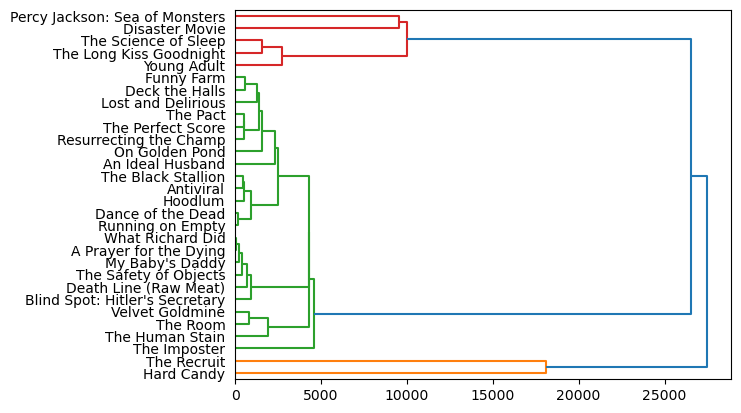

In [209]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline


Y = imdb_dataset['genre']
X = imdb_dataset.drop(['Unnamed: 0', 'title','genre', 'runtime', 'studio', 'thtr_rel_year', 'thtr_rel_month', 'thtr_rel_day', 'dvd_rel_year', 'dvd_rel_month', 'dvd_rel_day',
               'director', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'imdb_url', 'rt_url'],axis=1)

# Minimizing the rows by choosing 30 random movies
names = imdb_dataset['title'].sample(n=30, random_state=0)
X = X.sample(n=30, random_state=0)

Z = hierarchy.linkage(X.values, 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### Complete Link

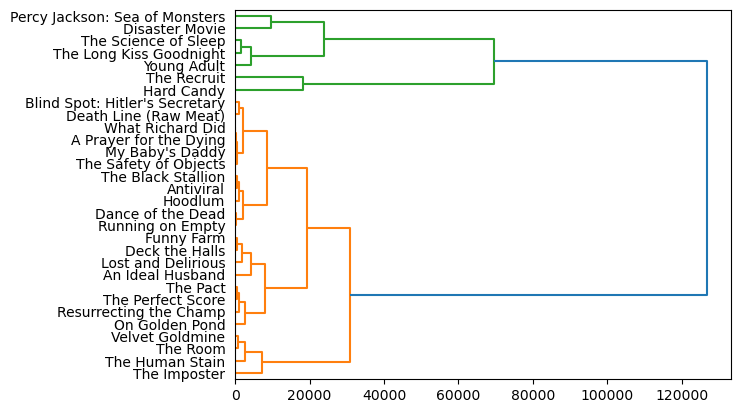

In [210]:
Z = hierarchy.linkage(X.values, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### Group Average

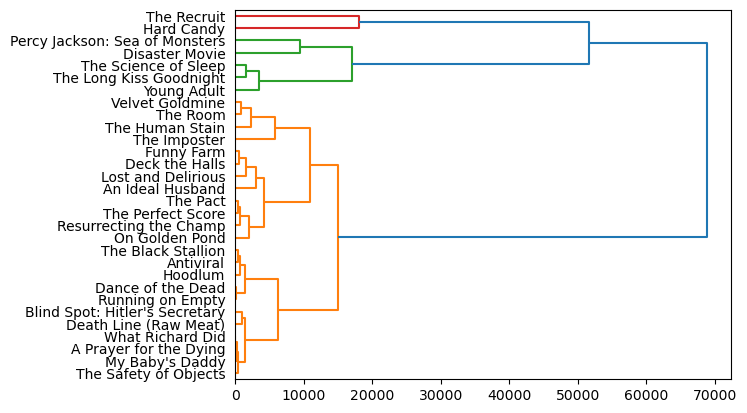

In [211]:
Z = hierarchy.linkage(X.values, 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

## Part 2: Text Mining

### Dataset for text mining:

In [212]:
text_dataset = [ 'Now for manners use has company believe parlors.',
'Least nor party who wrote while did. Excuse formed as is agreed admire so on result parish.',
'Put use set uncommonly announcing and travelling. Allowance sweetness direction to as necessary.',
'Principle oh explained excellent do my suspected conveying in.',
'Excellent you did therefore perfectly supposing described. ',
'Its had resolving otherwise she contented therefore.',
'Afford relied warmth out sir hearts sister use garden.',
'Men day warmth formed admire former simple.',
'Humanity declared vicinity continue supplied no an. He hastened am no property exercise of. ' ,
'Dissimilar comparison no terminated devonshire no literature on. Say most yet head room such just easy. ']


### Count Vector Implementation

In [213]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.CountVectorizer(min_df=2)
#vectorizer = sk_text.CountVectorizer(stop_words = 'english')

#min_df: ignore terms that have a document frequency < min_df.

matrix = vectorizer.fit_transform(text_dataset)

print(type(matrix))          # Compressed Sparse Row matrix
print(matrix.toarray())        #  convert it to numpy array

print(vectorizer.get_feature_names_out())

<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 0 0 0 0 0 1 0]
 [1 1 1 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0]]
['admire' 'as' 'did' 'excellent' 'formed' 'no' 'on' 'therefore' 'use'
 'warmth']


### Tfidf Vector Implementation

In [214]:
vectorizer = sk_text.TfidfVectorizer(
                             #stop_words='english',
                             #max_features = 1000,
                             min_df=2)


#max_features:  build a vocabulary that only consider the top max_features features ordered by term frequency across the corpus.

matrix = vectorizer.fit_transform(text_dataset)

print(type(matrix))          # Compressed Sparse Row matrix
print(matrix.toarray())        #  convert it to numpy array

print(vectorizer.get_feature_names_out())

<class 'scipy.sparse._csr.csr_matrix'>
[[0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.4472136  0.4472136  0.4472136  0.         0.4472136  0.
  0.4472136  0.         0.         0.        ]
 [0.         0.75262077 0.         0.         0.         0.
  0.         0.         0.65845424 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.57735027 0.57735027 0.         0.
  0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.65845424 0.75262077]
 [0.57735027 0.         0.         0.         0.57735027 0.
  0.         0.         0.         0.57735027]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        

2.4) Tfidf (term frequency-inverse document frequency) is a measure of how frequent a word appears in a set of documents. It is generally used in text analysis algorithms and for document searching. For example, Google search uses Tfidf for text preprocessing.

### Part 3:  Artificial Neural Network (ANN)

ANN Implementation

In [215]:
import pandas as pd
def change_to_binary_values(df, col_name):
    df[col_name] = (df[col_name] > df[col_name].median()).astype('int')
    
#Function to normalize columns
def normalize_numeric_minmax(df, name):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
        
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name], prefix=name)
    df = pd.concat([df, dummies], axis=1)
    df.drop(name, axis=1, inplace=True)
    return df

In [216]:
import pandas as pd
admission_dataset = pd.read_csv("./Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression-1.csv")
admission_dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [217]:
change_to_binary_values(admission_dataset, 'GRE Score')
change_to_binary_values(admission_dataset, 'TOEFL Score')
change_to_binary_values(admission_dataset, 'University Rating')
change_to_binary_values(admission_dataset, 'SOP')
change_to_binary_values(admission_dataset, 'LOR ')
change_to_binary_values(admission_dataset, 'CGPA')
admission_dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,1,1,1,1,1,1,1,0.92
1,2,1,0,1,1,1,1,1,0.76
2,3,0,0,0,0,0,0,1,0.72
3,4,1,1,0,0,0,1,1,0.80
4,5,0,0,0,0,0,0,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,1,1,1,1,1,1,1,0.87
496,497,1,1,1,1,1,1,1,0.96
497,498,1,1,1,1,1,1,1,0.93
498,499,0,0,1,1,1,0,0,0.73


In [218]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

admission_dataset = encode_text_dummy(admission_dataset, 'University Rating')

In [219]:
X = admission_dataset.drop('Chance of Admit ', axis=1)
y = admission_dataset['Chance of Admit ']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [222]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [223]:
y_pred = mlp.predict(X_test_scaled)

In [224]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.007377212223624457
